In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, Flatten, BatchNormalization, MaxPooling2D, concatenate, Dropout, Lambda, RepeatVector, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential, load_model
import numpy as np
import os
import tensorflow as tf
import cv2
import imutils
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, f1_score
import matplotlib.pyplot as plt

In [ ]:
!unzip /content/drive/MyDrive/DATASET.zip

In [ ]:
image_size=(96,96)
code={"EOSINOPHIL":0,"LYMPHOCYTE":1,"MONOCYTE":2,"NEUTROPHIL":3}

images = []
vectors = []
labels = []

def findedges(image):
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

def getimageconturs(edged):
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

def getboxes(contours,orig):
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (np.linalg.norm(tl - bl)) > 0 and (np.linalg.norm(tl - tr)) > 0:
            boxes.append(box)
    return boxes

def getcode(n):
    if type(n)==str:
        for x,y in code.items():
            if n==x:
                return y
    else:
        for x,y in code.items():
            if n==y:
                return x

In [ ]:
def load_and_preprocess_data(images_path, path):

    for label, folder_path in enumerate(path):
        vec_files = os.listdir(folder_path)
        for vec_file in vec_files:
            filename = vec_file.split(".")[0]
            class_name = getcode(label)
            image_path = f"{images_path}/{class_name}/{filename}.jpeg"
            vector_path = f"{folder_path}{vec_file}"

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # add padding to the image to better detect cell at the edge
            image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])

            #thresholding the image to get the target cell
            image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))

            # openning errosion then dilation
            kernel = np.ones((3, 3), np.uint8)
            kernel1 = np.ones((5, 5), np.uint8)
            img_erosion = cv2.erode(image1, kernel, iterations=2)
            image1 = cv2.dilate(img_erosion, kernel1, iterations=5)

            #detecting the blood cell
            edgedImage = findedges(image1)
            edgedContours = getimageconturs(edgedImage)
            edgedBoxes =  getboxes(edgedContours, image.copy())

            if len(edgedBoxes)==0:
                continue
            # get the large box and get its cordinate
            last = edgedBoxes[-1]
            max_x = int(max(last[:,0]))
            min_x = int( min(last[:,0]))
            max_y = int(max(last[:,1]))
            min_y = int(min(last[:,1]))

            # draw the contour and fill it
            mask = np.zeros_like(image)
            cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1)

            # any pixel but the pixels inside the contour is zero
            image[mask==0] = 0

            # extract th blood cell
            image = image[min_y:max_y, min_x:max_x]

            if (np.size(image)==0):
                continue
            # resize th image

            image = cv2.resize(image, image_size)
            image = image / 255.0  # Normalize pixel values to [0, 1]

            vector = np.loadtxt(vector_path, delimiter=',')

            images.append(image)
            vectors.append(vector)
            labels.append(label)


In [ ]:
paths = [
    '/content/DATASET/TRAIN/VECTORS/EOSINOPHIL/',
    '/content/DATASET/TRAIN/VECTORS/LYMPHOCYTE/',
    '/content/DATASET/TRAIN/VECTORS/MONOCYTE/',
    '/content/DATASET/TRAIN/VECTORS/NEUTROPHIL/',
]

test_paths = [
    '/content/DATASET/TEST/VECTORS/EOSINOPHIL/',
    '/content/DATASET/TEST/VECTORS/LYMPHOCYTE/',
    '/content/DATASET/TEST/VECTORS/MONOCYTE/',
    '/content/DATASET/TEST/VECTORS/NEUTROPHIL/'
]


In [ ]:
load_and_preprocess_data("/content/DATASET/TRAIN/IMAGES", paths)

In [ ]:
load_and_preprocess_data("/content/DATASET/TEST/IMAGES", test_paths)

In [ ]:
images,vectors,labels=shuffle(images,vectors,labels,random_state=10)

In [ ]:
images = np.array(images)
vectors = np.array(vectors)
labels = np.array(labels)

In [ ]:
# Generate Train and Test using 80/20 split
train_image, test_image, train_vector, test_vector, train_label, test_label = train_test_split(images, vectors, labels, test_size=0.2, random_state=42)

In [ ]:
train_image = np.array(train_image, dtype = 'float32')
train_vector = np.array(train_vector, dtype = 'float32')
train_label = np.array(train_label, dtype = 'int32')

test_image = np.array(test_image, dtype = 'float32')
test_vector = np.array(test_vector, dtype = 'float32')
test_label = np.array(test_label, dtype = 'int32')

In [ ]:
print(train_image.shape, train_vector.shape, train_label.shape)
print(test_image.shape, test_vector.shape, test_label.shape)

(9716, 96, 96, 3) (9716, 10) (9716,)
(2430, 96, 96, 3) (2430, 10) (2430,)


In [ ]:
def create_model_without_knowledge():
    # Image input for MobileNetV2 (resize images to 224x224)
    image_input = Input(shape=(96, 96, 3))
    base_model = MobileNetV2(weights=None, include_top=False, input_tensor=image_input)

    # Additional processing layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.25)(x)

    # Output layer
    output = Dense(4, activation='softmax')(x)  # Assuming 4 classes

    # Define the model
    model = Model(inputs=image_input, outputs=output)

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Create and compile the model
model_without_knowledge_mobilenetv2 = create_model_without_knowledge()

# Display model summary
model_without_knowledge_mobilenetv2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 48, 48, 32)           0         ['bn_Conv1[0][0]']        

In [ ]:
model_without_knowledge_mobilenetv2.fit(train_image, train_label, validation_split=0.1, epochs=30, batch_size=32)

Epoch 1/30
274/274 [==============================] - 53s 52ms/step - loss: 0.8516 - accuracy: 0.6499 - val_loss: 1.4101 - val_accuracy: 0.2274
Epoch 2/30
274/274 [==============================] - 10s 38ms/step - loss: 0.3838 - accuracy: 0.8596 - val_loss: 1.4556 - val_accuracy: 0.2274
Epoch 3/30
274/274 [==============================] - 12s 42ms/step - loss: 0.2826 - accuracy: 0.8992 - val_loss: 1.5932 - val_accuracy: 0.2274
Epoch 4/30
274/274 [==============================] - 16s 59ms/step - loss: 0.2584 - accuracy: 0.9117 - val_loss: 1.9718 - val_accuracy: 0.2274
Epoch 5/30
274/274 [==============================] - 12s 44ms/step - loss: 0.1874 - accuracy: 0.9318 - val_loss: 2.1768 - val_accuracy: 0.2274
Epoch 6/30
274/274 [==============================] - 11s 40ms/step - loss: 0.2107 - accuracy: 0.9260 - val_loss: 2.0394 - val_accuracy: 0.2274
Epoch 7/30
274/274 [==============================] - 11s 42ms/step - loss: 0.1838 - accuracy: 0.9377 - val_loss: 2.4712 - val_accuracy:

In [ ]:
loss1,accuracy1=model_without_knowledge_mobilenetv2.evaluate(test_image, test_label)
print("the accuracy of mobilenetv2 model (pretrained architecture) without knowledge is : ",accuracy1)

76/76 [==============================] - 2s 24ms/step - loss: 1.7922 - accuracy: 0.7449
the accuracy of mobilenetv2 model (pretrained architecture) without knowledge is :  0.7448559403419495


In [ ]:
model_without_knowledge_mobilenetv2.save('/content/drive/My Drive/MobileNetV2PretrainedArchitectureWithoutKnowledge.keras')

In [ ]:
model_without_knowledge_mobilenetv2.save('/content/drive/My Drive/MobileNetV2PretrainedArchitectureWithoutKnowledge.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def create_model_with_knowledge():
    # Image input for MobileNetV2 (resize images to 224x224)
    image_input = Input(shape=(96, 96, 3))
    base_model = MobileNetV2(weights=None, include_top=False, input_tensor=image_input)

    # Additional processing layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Vector input
    vector_input = Input(shape=(10,))

    # Concatenate image and vector features
    z = concatenate([vector_input, x])
    z = Dense(64)(z)
    z = Activation('relu')(z)
    z = Dropout(0.25)(z)

    z = Dense(64)(z)
    z = Activation('relu')(z)
    z = Dropout(0.25)(z)

    # Output layer
    output = Dense(4, activation='softmax')(z)

    # Define the model
    model = Model(inputs=[image_input, vector_input], outputs=output)

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Create and compile the model
model_with_knowledge_mobilenetv2 = create_model_with_knowledge()

# Display model summary
model_with_knowledge_mobilenetv2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 48, 48, 32)           0         ['bn_Conv1[0][0]']      

In [ ]:
model_with_knowledge_mobilenetv2.fit([train_image, train_vector], train_label, validation_split=0.1, epochs=30, batch_size=32)

Epoch 1/30
274/274 [==============================] - 43s 62ms/step - loss: 0.7574 - accuracy: 0.6762 - val_loss: 0.4817 - val_accuracy: 0.9918
Epoch 2/30
274/274 [==============================] - 11s 40ms/step - loss: 0.1598 - accuracy: 0.9732 - val_loss: 0.0465 - val_accuracy: 0.9938
Epoch 3/30
274/274 [==============================] - 11s 40ms/step - loss: 0.0829 - accuracy: 0.9871 - val_loss: 0.0387 - val_accuracy: 0.9938
Epoch 4/30
274/274 [==============================] - 12s 45ms/step - loss: 0.0647 - accuracy: 0.9880 - val_loss: 0.0399 - val_accuracy: 0.9928
Epoch 5/30
274/274 [==============================] - 11s 41ms/step - loss: 0.0522 - accuracy: 0.9903 - val_loss: 0.0421 - val_accuracy: 0.9928
Epoch 6/30
274/274 [==============================] - 12s 43ms/step - loss: 0.0735 - accuracy: 0.9872 - val_loss: 0.0447 - val_accuracy: 0.9928
Epoch 7/30
274/274 [==============================] - 11s 41ms/step - loss: 0.1205 - accuracy: 0.9667 - val_loss: 0.0460 - val_accuracy:

In [ ]:
loss2,accuracy2=model_with_knowledge_mobilenetv2.evaluate([test_image, test_vector], test_label)
print("the accuracy of mobilenetv2 model (pretrained architecture) with knowledge is : ",accuracy2)

76/76 [==============================] - 1s 13ms/step - loss: 0.0481 - accuracy: 0.9926
the accuracy of mobilenetv2 model (pretrained architecture) with knowledge is :  0.9925925731658936


In [ ]:
model_with_knowledge_mobilenetv2.save('/content/drive/My Drive/MobileNetV2PretrainedArchitectureWithKnowledge.keras')

In [ ]:
model_with_knowledge_mobilenetv2.save('/content/drive/My Drive/MobileNetV2PretrainedArchitectureWithKnowledge.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Mobile Net v2 Pretrained Architecture Without Knowledge Results
76/76 [==============================] - 2s 10ms/step


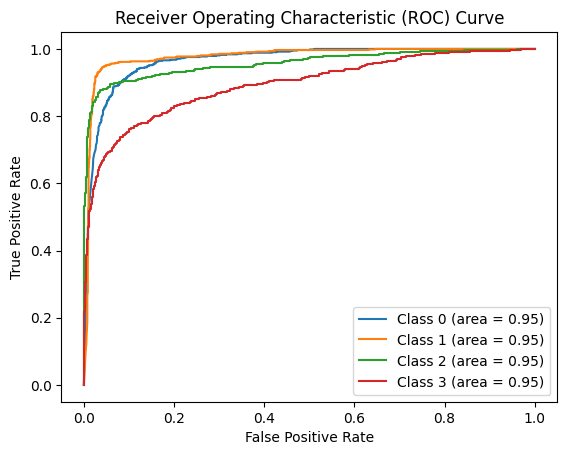

Accuracy: 0.7448559670781894
Class-wise Accuracy: [0.9822580645161291, 0.8938906752411575, 0.7203389830508474, 0.36789297658862874]
Precision: 0.841276159626723
Recall: 0.7448559670781894
Specificity: 0.9983606557377049
F1 Score: 0.7901353952906439
AUC: 0.9483586047671345


In [ ]:
num_classes = 4

def analyze_results(model, X_test, y_test):
    # Evaluate the model
    y_pred = model.predict(X_test)
    y_true = y_test

    # Calculate overall accuracy
    accuracy = np.sum(np.argmax(y_pred, axis=1) == y_true) / len(y_true)

    # Calculate accuracy for each class
    class_accuracy = []
    for cls in range(num_classes):
        cls_indices = np.where(y_true == cls)[0]
        cls_accuracy = np.sum(np.argmax(y_pred[cls_indices], axis=1) == cls) / len(cls_indices)
        class_accuracy.append(cls_accuracy)

    # Calculate precision
    precision = precision_score(y_true, y_pred.argmax(axis=1), average='weighted')

    # Calculate recall
    recall = recall_score(y_true, y_pred.argmax(axis=1), average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred.argmax(axis=1))

    # Calculate specificity
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Calculate AUC
    auc = roc_auc_score(y_true, y_pred, multi_class='ovr')

    # Plot ROC curve
    fpr = dict()
    tpr = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_pred[:, i], pos_label=i)
        plt.plot(fpr[i], tpr[i], linestyle='-', label=f'Class {i} (area = %0.2f)' % auc)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    # Print metrics
    print("Accuracy:", accuracy)
    print("Class-wise Accuracy:", class_accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Specificity:", specificity)
    print("F1 Score:", f1_score)
    print("AUC:", auc)

# Perform result analysis for model without knowledge
print("Mobile Net v2 Pretrained Architecture Without Knowledge Results")
analyze_results(model_without_knowledge_mobilenetv2, test_image, test_label)




MobileNetV2 Pretrained Architecture with knowledge Results
76/76 [==============================] - 2s 12ms/step


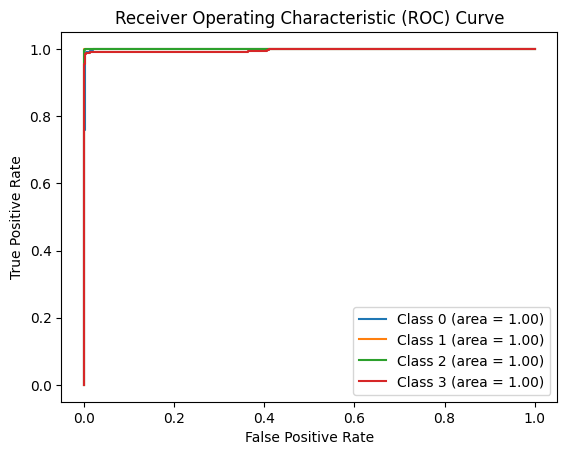

Accuracy: 0.9925925925925926
Class-wise Accuracy: [0.9887096774193549, 0.9967845659163987, 1.0, 0.9849498327759197]
Precision: 0.9925927824471656
Recall: 0.9925925925925926
Specificity: 1.0
F1 Score: 0.99259268751987
AUC: 0.9987308254835319


In [ ]:
# Perform result analysis for model with knowledge
print("MobileNetV2 Pretrained Architecture with knowledge Results")
analyze_results(model_with_knowledge_mobilenetv2, [test_image, test_vector], test_label)

## **Class-wise Results**

In [ ]:
from statistics import mean

def analyze_results_class_wise(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_true = y_test

    accuracy = accuracy_score(y_true, np.argmax(y_pred, axis=1))

    num_classes = 4
    class_accuracy = []
    for cls in range(num_classes):
        cls_indices = np.where(y_true == cls)[0]
        cls_accuracy = accuracy_score(y_true[cls_indices], np.argmax(y_pred[cls_indices], axis=1))
        class_accuracy.append(cls_accuracy)

    # Calculate precision, recall, specificity, and F1 score for each class
    precision = precision_score(y_true, np.argmax(y_pred, axis=1), average=None)
    recall = recall_score(y_true, np.argmax(y_pred, axis=1), average=None)
    conf_matrix = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
    specificity = conf_matrix.diagonal() / np.sum(conf_matrix, axis=1)
    f1 = f1_score(y_true, np.argmax(y_pred, axis=1), average=None)

    # Print metrics
    print("Overall Accuracy:", accuracy)
    print("Class-wise Accuracy:", class_accuracy)
    print("Precision (Per Class):", precision)
    print("Recall (Per Class):", recall)
    print("Specificity (Per Class):", specificity)
    print("F1 Score (Per Class):", f1)

    print("------------Averages------------")
    print(f"Average Accuracy: {mean(class_accuracy)}")
    print(f"Average Precision: {mean(precision)}")
    print(f"Average Specificity: {mean(specificity)}")
    print(f"Average F1-Score: {mean(f1)}")
    print()

In [ ]:
pretrained_model_with_knowledge = load_model('/content/drive/MyDrive/MobileNetV2PretrainedModelWithKnowledge.keras')
pretrained_model_without_knowledge = load_model('/content/drive/MyDrive/MobileNetV2PretrainedModelWithoutKnowledge.keras')
pretrained_architecture_with_knowledge = load_model('/content/drive/MyDrive/MobileNetV2PretrainedArchitectureWithKnowledge.keras')
pretrained_architecture_without_knowledge = load_model('/content/drive/MyDrive/MobileNetV2PretrainedArchitectureWithoutKnowledge.keras')

model_pairs = [
    (pretrained_model_with_knowledge, pretrained_model_without_knowledge),
    (pretrained_architecture_with_knowledge, pretrained_architecture_without_knowledge)
]

In [ ]:
# for model_with_knowledge, model_without_knowledge in model_pairs:
#   analyze_results_class_wise(model_with_knowledge, [test_image, test_vector], test_label)
#   analyze_results_class_wise(model_without_knowledge, test_image, test_label)

analyze_results_class_wise(pretrained_model_without_knowledge, test_image, test_label)

76/76 [==============================] - 6s 17ms/step
Overall Accuracy: 0.9543209876543209
Class-wise Accuracy: [0.9693548387096774, 0.9967845659163987, 0.9203389830508475, 0.9280936454849499]
Precision (Per Class): [0.97564935 0.90379009 0.98907104 0.95854922]
Recall (Per Class): [0.96935484 0.99678457 0.92033898 0.92809365]
Specificity (Per Class): [0.96935484 0.99678457 0.92033898 0.92809365]
F1 Score (Per Class): [0.97249191 0.94801223 0.95346795 0.94307562]
------------Averages------------
Average Accuracy: 0.9536430082904683
Average Precision: 0.9567649247905503
Average Specificity: 0.9536430082904683
Average F1-Score: 0.9542619280299363

